In [36]:
#imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
import getdata
import densities
from scipy.optimize import curve_fit

In [37]:
def getdensityprofile(nr_bins = 1000, bin_distr = "adaptive"):
    bin_distr_options = ["linear", "logarithmic", "adaptive"]
    coords = getdata.coordskpc()
    mass = getdata.masssolar()
    
    if(bin_distr not in bin_distr_options):
        print(f"Error: bin_distr contains no valid distribution type. Choose from: " + str(bin_distr_options) + ", performing linear distribution instead.")
        bin_distr = "linear"

    if((nr_bins <= 1) or (isinstance(nr_bins, int) == False)):
        print(f"Error: bin amount must be a positive integer. Will now default to 1000 bins.")
        nr_bins = 1000

    coord_com = np.sum(coords,axis=0) / len(coords)
    coords_centred = coords - coord_com
    com_dist = np.sqrt(np.sum(coords_centred**2, axis=1))

    r_min = np.min(com_dist)
    r_max = np.max(com_dist)
    bins = np.linspace(r_min, r_max, nr_bins) 
    
    if(bin_distr == "adaptive"):
        com_dist_sorted = np.sort(com_dist)
        nr_particles = len(com_dist_sorted)

        bin_size = nr_particles // nr_bins
        bin_limit = nr_bins*bin_size
        bins = com_dist_sorted[:bin_limit].reshape(nr_bins, bin_size)

        bin_inner_bound = bins[:, 0]         
        bin_outer_bound = bins[:, -1]       
        bin_centre = np.mean(bins, axis=1)  

        bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
        bin_density = bin_size*mass / bin_volume
        bin_poisson_error = np.sqrt(bin_size)*mass / bin_volume
        return bin_centre, bin_density, bin_poisson_error
        
    if(bin_distr == "linear"):
        bins = np.linspace(r_min, r_max, nr_bins)
    if(bin_distr == "logarithmic"):
        bins = np.logspace(np.log10(r_min.value), np.log10(r_max.value), nr_bins) * r_min.unit
    
    bin_counts, bin_edges = np.histogram(com_dist, bins=bins)
    bin_inner_bound = bin_edges[:-1]
    bin_outer_bound = bin_edges[1:]
    bin_centre = (bin_outer_bound + bin_inner_bound) / 2
    
    bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
    bin_density = bin_counts*mass / bin_volume 
    bin_poisson_error = bin_density / np.sqrt(bin_counts)

    #remove zero density points to avoid logarithmic errors and fit errors
    nonzero_indices = [i for i, density in enumerate(bin_density) if density > 0.0]

    bin_density = [bin_density[i] for i in nonzero_indices] * bin_density.unit
    bin_centre = [bin_centre[i] for i in nonzero_indices] * bin_centre.unit
    bin_poisson_error = [bin_poisson_error[i] for i in nonzero_indices] * bin_poisson_error.unit

    return bin_centre, bin_density, bin_poisson_error

In [140]:
#all potentials with their log version for fitting
from astropy import units
import numpy as np

def hernquist(r_kpc, mass_sol, param_kpc):
    constant = 2*mass_sol / (4*np.pi*param_kpc)
    density = constant / ((r_kpc / param_kpc) * (1 + r_kpc/param_kpc)**3)
    return density

def loghernquist(logr_kpc, mass_sol, param_kpc):
    r_kpc = 10**logr_kpc
    constant = 2*mass_sol / (4*np.pi*param_kpc)
    density = constant / ((r_kpc / param_kpc) * (1 + r_kpc/param_kpc)**3)
    return np.log10(density)

def plummer(r_kpc, mass_sol, param_kpc):
    constant = (3*mass_sol)/(4*np.pi*(param_kpc**3))
    density = constant*(1 + (r_kpc**2)/(param_kpc**2))**(-5/2)
    return density

def logplummer(logr_kpc, mass_sol, param_kpc):
    r_kpc = 10**logr_kpc
    constant = (3*mass_sol)/(4*np.pi*(param_kpc**3))
    density = constant*(1 + (r_kpc**2)/(param_kpc**2))**(-5/2)
    return np.log10(density)

def doublepowerlaw(r_kpc, ampl_solm, a_kpc, alpha, beta):
    constant = ampl_solm/(4*np.pi*(a_kpc**3))
    density = constant/(((r_kpc/a_kpc)**alpha)*(1.0+(r_kpc/a_kpc)**(beta-alpha)))
    return density

def logdoublepowerlaw(logr_kpc, ampl_solm, a_kpc, alpha, beta):
    r_kpc = 10**logr_kpc
    constant = ampl_solm/(4*np.pi*(a_kpc**3))
    density = constant/(((r_kpc/a_kpc)**alpha)*(1.0+(r_kpc/a_kpc)**(beta-alpha)))
    return np.log10(density)

def burkert(r_kpc, ampl_solm, a_kpc):
    density = ampl_solm / ((1 + (r_kpc/a_kpc))*(1 + (r_kpc/a_kpc)**2))
    return density

def logburkert(logr_kpc, ampl_solm, a_kpc):
    r_kpc = 10**logr_kpc
    density = ampl_solm / ((1 + (r_kpc/a_kpc))*(1 + (r_kpc/a_kpc)**2))
    return np.log10(density)

def sphericalcoreddehnen(r_kpc, ampl_solm, a_kpc):
    constant = ampl_solm / (12*np.pi*(a_kpc)**3)
    density = constant / (1 + (r_kpc/a_kpc)**4)
    return density

def logsphericalcoreddehnen(logr_kpc, ampl_solm, a_kpc):
    r_kpc = 10**logr_kpc
    constant = ampl_solm / (12*np.pi*(a_kpc)**3)
    density = constant / (1 + (r_kpc/a_kpc)**4)
    return np.log10(density)

def sphericaldehnen(r_kpc, ampl_solm, a_kpc, alpha):
    constant = ampl_solm * (3 - alpha) / (4*np.pi*(a_kpc)**3) 
    fraction = r_kpc/a_kpc
    density = constant / ((fraction**alpha) * (1.0 + fraction)**(4.0 - alpha))
    return density

def logsphericaldehnen(logr_kpc, ampl_solm, a_kpc, alpha):
    r_kpc = 10**logr_kpc
    constant = ampl_solm * (3 - alpha) / (4*np.pi*(a_kpc)**3) 
    fraction = r_kpc/a_kpc
    density = constant / ((fraction**alpha) * (1.0 + fraction)**(4.0 - alpha))
    return np.log10(density)

def jaffe(r_kpc, ampl_solm, a_kpc):
    constant = ampl_solm / (4*np.pi*(a_kpc)**3)
    fraction = r_kpc / a_kpc
    density = constant / (fraction**2 * (1.0 + fraction)**2)
    return density

def logjaffe(logr_kpc, ampl_solm, a_kpc):
    r_kpc = 10**logr_kpc
    constant = ampl_solm / (4*np.pi*(a_kpc)**3)
    fraction = r_kpc / a_kpc
    density = constant / (fraction**2 * (1.0 + fraction)**2)
    return np.log10(density)

def nfw(r_kpc, ampl_solm, a_kpc):
    constant = ampl_solm / (4*np.pi*(a_kpc)**3)
    fraction = r_kpc / a_kpc
    density = constant / (fraction * (1.0 + fraction)**2)
    return density

def lognfw(logr_kpc, ampl_solm, a_kpc):
    r_kpc = 10**logr_kpc
    constant = ampl_solm / (4*np.pi*(a_kpc)**3)
    fraction = r_kpc / a_kpc
    density = constant / (fraction * (1.0 + fraction)**2)
    return np.log10(density)

def powerspherical(r_kpc, ampl_solm, a_kpc, alpha):
    density = (ampl_solm / (a_kpc**3)) * (a_kpc / r_kpc)**alpha
    return density

def logpowerspherical(logr_kpc, ampl_solm, a_kpc, alpha):
    r_kpc = 10**logr_kpc
    density = (ampl_solm / (a_kpc**3)) * (a_kpc / r_kpc)**alpha
    return np.log10(density)

def powersphericalwcutoff(r_kpc, ampl_solm, a_kpc, cutoff_kpc, alpha):
    density = ampl_solm * ((a_kpc/r_kpc)**alpha) * np.exp(-(r_kpc/cutoff_kpc)**2)
    return density

def logpowersphericalwcutoff(logr_kpc, ampl_solm, a_kpc, cutoff_kpc, alpha):
    r_kpc = 10**logr_kpc
    density = ampl_solm * ((a_kpc/r_kpc)**alpha) * np.exp(-(r_kpc/cutoff_kpc)**2)
    return np.log10(density)

def pseudoisothermal(r_kpc, ampl_solm, a_kpc):
    constant = ampl_solm / (4*np.pi*(a_kpc)**3)
    density = constant / (1.0 + (r_kpc/a_kpc)**2)
    return density

def logpseudoisothermal(logr_kpc, ampl_solm, a_kpc):
    r_kpc = 10**logr_kpc
    constant = ampl_solm / (4*np.pi*(a_kpc)**3)
    density = constant / (1.0 + (r_kpc/a_kpc)**2)
    return np.log10(density)

In [171]:
def getdensitylogfit(potential = "doublepowerlaw", nr_bins = 100, bin_distr = "adaptive"):
    potential_options = ["hernquist", "plummer", "doublepowerlaw", "burkert", "sphericalcoreddehnen", "sphericaldehnen", "jaffe", "nfw", "powerspherical", "powersphericalwcutoff", "pseudoisothermal"]
    if potential is None:
        return potential_options
    if(potential not in potential_options):
        print(f"Error: Unimplemented potential given. Choose from: " + str(potential_options) + ", performing doublepowerlaw fit instead.")
        potential = "doublepowerlaw"
    
    total_mass = getdata.masssolar() * len(getdata.coordskpc())
    bcentre, bdensity, bpoissonerror = getdensityprofile(nr_bins = nr_bins, bin_distr = bin_distr)
    centre_log = np.log10(bcentre.value)
    density_log = np.log10(bdensity.value)
    poisson_log = np.log10(bpoissonerror.value)
    
    popt = []
    pcov = []
    param = []
    param_error = []
    
    if(potential == "hernquist"):
        popt, pcov = curve_fit(
        loghernquist,
        centre_log,
        density_log,
        p0=[total_mass.value, 50]
        )
        
        mass_solfit, b_kpcfit = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit]

    if(potential == "plummer"):
        popt, pcov = curve_fit(
        logplummer,
        centre_log,
        density_log,
        p0=[total_mass.value, 50]
        )
        
        mass_solfit, b_kpcfit = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit]

    if(potential == "doublepowerlaw"):
        popt, pcov = curve_fit(
        logdoublepowerlaw,
        centre_log,
        density_log,
        p0=[total_mass.value, 50, 1.5, 1.5]
        )
        mass_solfit, b_kpcfit, alpha, beta = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit, alpha, beta]

    if(potential == "burkert"):
        popt, pcov = curve_fit(
        logburkert,
        centre_log,
        density_log,
        p0=[total_mass.value, 50]
        )
        
        mass_solfit, b_kpcfit, = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit]

    if(potential == "sphericalcoreddehnen"):
        popt, pcov = curve_fit(
        logsphericalcoreddehnen,
        centre_log,
        density_log,
        p0=[total_mass.value, 50]
        )
        
        mass_solfit, b_kpcfit, = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit]

    if(potential == "sphericaldehnen"):
        popt, pcov = curve_fit(
        logsphericaldehnen,
        centre_log,
        density_log,
        p0=[total_mass.value, 50, 1.5]
        )
        
        mass_solfit, b_kpcfit, alpha = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit, alpha]

    if(potential == "jaffe"):
        popt, pcov = curve_fit(
        logjaffe,
        centre_log,
        density_log,
        p0=[total_mass.value, 50]
        )
        
        mass_solfit, b_kpcfit = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit]

    if(potential == "nfw"):
        popt, pcov = curve_fit(
        lognfw,
        centre_log,
        density_log,
        p0=[total_mass.value, 10]
        )
        
        mass_solfit, b_kpcfit = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit]

    if(potential == "powerspherical"):
        popt, pcov = curve_fit(
        logpowerspherical,
        centre_log,
        density_log,
        p0=[total_mass.value, 50, 1.5]
        )
        
        mass_solfit, b_kpcfit, alpha = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit, alpha]

    if(potential == "powersphericalwcutoff"):
        popt, pcov = curve_fit(
        logpowersphericalwcutoff,
        centre_log,
        density_log,
        p0=[total_mass.value, 50, 50, 1.5]
        )
        
        mass_solfit, b_kpcfit, cutoff_kpcfit, alpha = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        cutoff_kpcfit = cutoff_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit, cutoff_kpcfit, alpha]

    if(potential == "pseudoisothermal"):
        popt, pcov = curve_fit(
        logpseudoisothermal,
        centre_log,
        density_log,
        p0=[total_mass.value, 50]
        )
        
        mass_solfit, b_kpcfit = popt
        mass_solfit = mass_solfit * total_mass.unit
        b_kpcfit = b_kpcfit * bcentre.unit
        param = [mass_solfit, b_kpcfit]

    param_error = np.sqrt(np.diag(pcov))
    print("STD of the parameters: " + str(param_error))
    
    return param, param_error, potential, bcentre, bdensity

In [172]:
def show_fitparameters_errors(param, bdensity, fitdensity, potentialname):
    bindensity_log = np.log10(bdensity.value)
    fitdensity_log = np.log10(fitdensity.value)
    
    residuals = bindensity_log - fitdensity_log         
    rms_error = np.sqrt(np.mean(residuals**2))                          
    
    squaresum_residual = np.sum(residuals**2)
    squaresum_total = np.sum((bindensity_log - np.mean(bindensity_log))**2)
    rsquared_error = 1.0 - (squaresum_residual / squaresum_total)            #relative error

    print("optimal parameters for " + potentialname + ": " + str(param))
    print("RMSE of " + potentialname + " fit: " + str(rms_error))
    print("RSQUARED of " + potentialname + " fit: " + str(rsquared_error))   #RSQUARED of 1 is best.

In [173]:
#density fit plotting
def plotdensityfit(potential = "doublepowerlaw", nr_bins = 100, bin_distr = "adaptive"):
    if potential is None:
        print(f"Error: Unimplemented potential given. Choose from: " + getdensitylogfit(potential=None) + ", performing doublepowerlaw fit instead.")
        potential = "doublepowerlaw"

    param, param_error, potential, bcentre, bdensity = getdensitylogfit(potential=potential, nr_bins=nr_bins, bin_distr=bin_distr)

    densityfit = []
    if(potential == "hernquist"):
        densityfit = hernquist(bcentre, *param)
    if(potential == "plummer"):
        densityfit = plummer(bcentre, *param)
    if(potential == "doublepowerlaw"):
        densityfit = doublepowerlaw(bcentre, *param)
    if(potential == "burkert"):
        densityfit = burkert(bcentre, *param)
    if(potential == "sphericalcoreddehnen"):
        densityfit = sphericalcoreddehnen(bcentre, *param)
    if(potential == "sphericaldehnen"):
        densityfit = sphericaldehnen(bcentre, *param)
    if(potential == "jaffe"):
        densityfit = jaffe(bcentre, *param)
    if(potential == "nfw"):
        densityfit = nfw(bcentre, *param)
    if(potential == "powerspherical"):
        densityfit = powerspherical(bcentre, *param)
    if(potential == "powersphericalwcutoff"):
        densityfit = powersphericalwcutoff(bcentre, *param)
    if(potential == "pseudoisothermal"):
        densityfit = pseudoisothermal(bcentre, *param)

    #calculate errors
    show_fitparameters_errors(param, bdensity, densityfit, potential)
    
    fig, axs = plt.subplots(2, sharex=False, sharey=False)
    fig.suptitle(potential + " density profile fit")
    axs[0].scatter(bcentre, bdensity, s=1, label="data")
    axs[0].plot(bcentre, densityfit, c="red", label="fit")
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    
    axs[1].scatter(bcentre, bdensity, s=1, label="data")
    axs[1].plot(bcentre, densityfit, c="red", label="fit")
    axs[1].set_xscale("linear")
    axs[1].set_yscale("linear")

    fig.supxlabel("Radius (" + str(bcentre.unit) + ")") 
    fig.supylabel("Density (" + str(bdensity.unit) + ")") 
    
    #plt.supxlabel("Radius (" + str(bcentre.unit) + ")")
    #plt.supylabel("Density (" + str(bdensity.unit) + ")")
    #plt.suptitle(potential + " fit of the density profile")
    plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\niels\AppData\Local\Temp\ipykernel_13884\1058241007.py:14: RuntimeWarning: invalid value encountered in log10
  return np.log10(density)


STD of the parameters: [2.09669693e+08 1.86160909e+00]
optimal parameters for hernquist: [<Quantity 7.42176597e+08 solMass>, <Quantity 10.18415833 kpc>]
RMSE of hernquist fit: 0.5350978768214326
RSQUARED of hernquist fit: 0.937054925767901


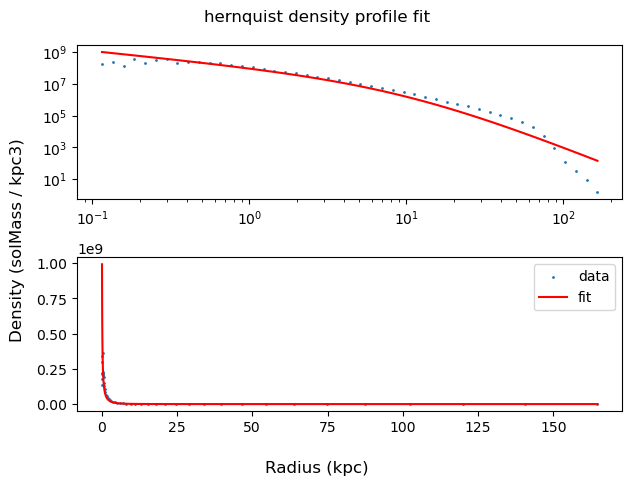

In [174]:
plotdensityfit(potential = "hernquist", nr_bins = 50, bin_distr = "logarithmic")

STD of the parameters: [1.61296423e+10 1.04038792e+00]
optimal parameters for plummer: [<Quantity 1.83456526e+11 solMass>, <Quantity 17.26412415 kpc>]
RMSE of plummer fit: 0.26437592402292676
RSQUARED of plummer fit: 0.9242189710545838


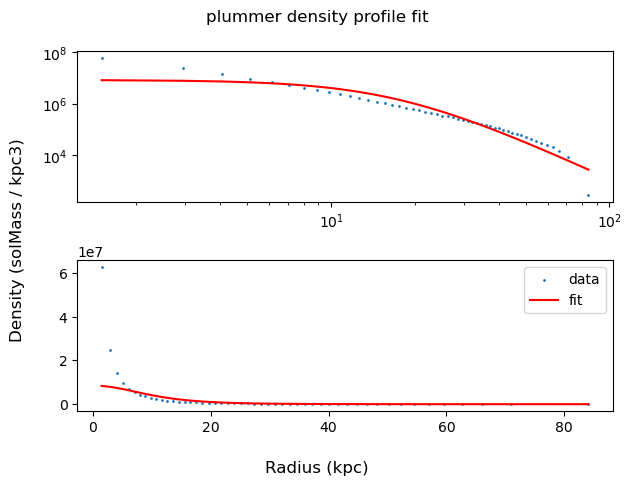

In [185]:
plotdensityfit(potential = "plummer", nr_bins = 50, bin_distr = "adaptive")

C:\Users\niels\AppData\Local\Temp\ipykernel_13884\1058241007.py:35: RuntimeWarning: invalid value encountered in power
  density = constant/(((r_kpc/a_kpc)**alpha)*(1.0+(r_kpc/a_kpc)**(beta-alpha)))
C:\Users\niels\AppData\Local\Temp\ipykernel_13884\1058241007.py:36: RuntimeWarning: invalid value encountered in log10
  return np.log10(density)


STD of the parameters: [7.58557551e+09 1.18919680e+00 4.23330467e-02 1.08097898e+00]
optimal parameters for doublepowerlaw: [<Quantity 1.408539e+11 solMass>, <Quantity 61.59979773 kpc>, np.float64(2.137631284420001), np.float64(15.157640182989251)]
RMSE of doublepowerlaw fit: 0.09269547919448659
RSQUARED of doublepowerlaw fit: 0.9906839073220005


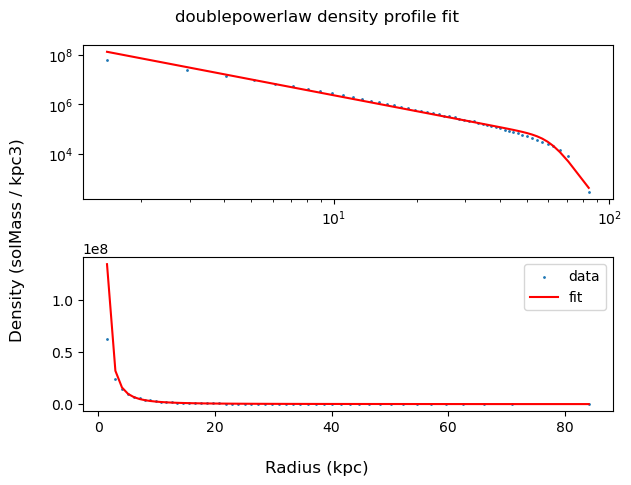

In [176]:
plotdensityfit(potential = "doublepowerlaw", nr_bins = 50, bin_distr = "adaptive")

C:\Users\niels\AppData\Local\Temp\ipykernel_13884\1058241007.py:45: RuntimeWarning: invalid value encountered in log10
  return np.log10(density)


STD of the parameters: [2.14949189e+07 7.01860382e-01]
optimal parameters for burkert: [<Quantity 55354574.19584002 solMass>, <Quantity 4.74475789 kpc>]
RMSE of burkert fit: 0.2338255563423557
RSQUARED of burkert fit: 0.940721030514869


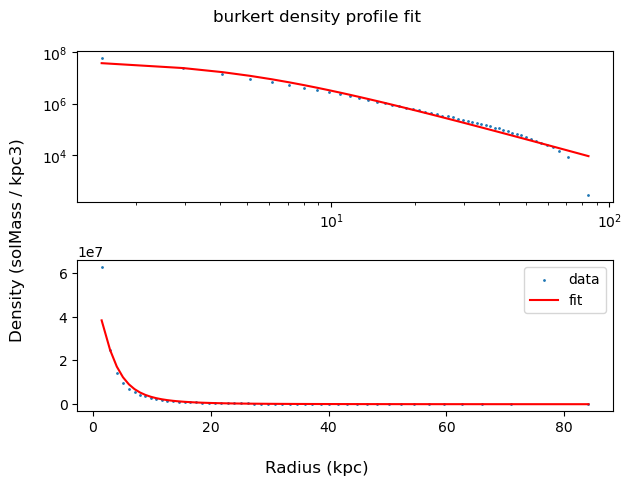

In [177]:
plotdensityfit(potential = "burkert", nr_bins = 50, bin_distr = "adaptive")

C:\Users\niels\AppData\Local\Temp\ipykernel_13884\1058241007.py:56: RuntimeWarning: invalid value encountered in log10
  return np.log10(density)


STD of the parameters: [5.51068968e+10 8.91696010e-01]
optimal parameters for sphericalcoreddehnen: [<Quantity 5.57640254e+11 solMass>, <Quantity 12.45333224 kpc>]
RMSE of sphericalcoreddehnen fit: 0.29733842291800716
RSQUARED of sphericalcoreddehnen fit: 0.904144119744281


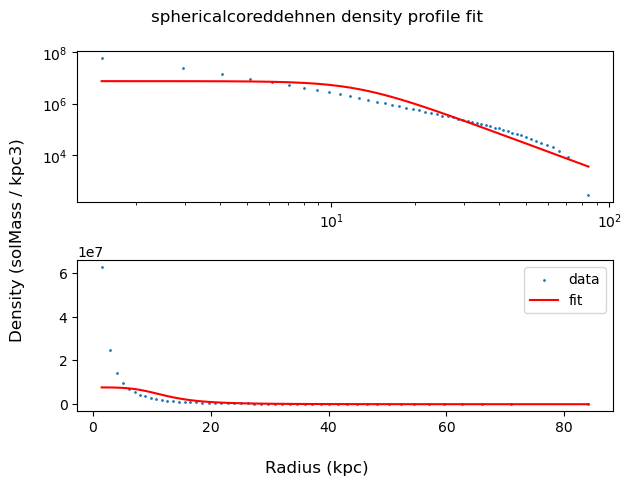

In [178]:
plotdensityfit(potential = "sphericalcoreddehnen", nr_bins = 50, bin_distr = "adaptive")

C:\Users\niels\AppData\Local\Temp\ipykernel_13884\1058241007.py:68: RuntimeWarning: invalid value encountered in power
  density = constant / ((fraction**alpha) * (1.0 + fraction)**(4.0 - alpha))


STD of the parameters: [1.89112160e+10 5.39806459e+00 5.96105509e-01]
optimal parameters for sphericaldehnen: [<Quantity 2.22519817e+11 solMass>, <Quantity 13.35322725 kpc>, np.float64(0.6299762044174955)]
RMSE of sphericaldehnen fit: 0.20862610883069047
RSQUARED of sphericaldehnen fit: 0.9528095619890862


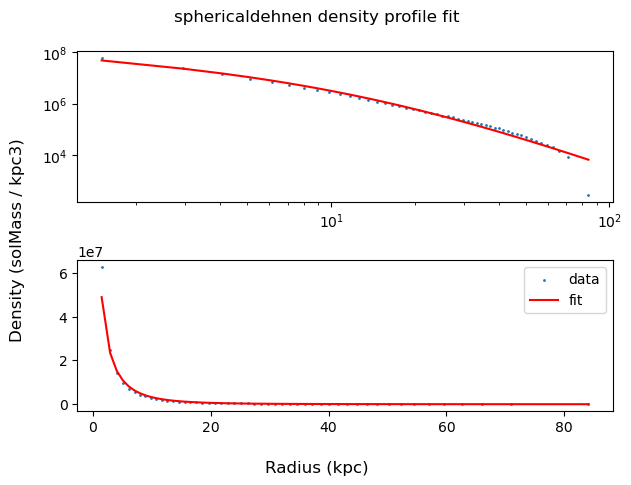

In [179]:
plotdensityfit(potential = "sphericaldehnen", nr_bins = 50, bin_distr = "adaptive")

STD of the parameters: [3.14337577e+10 1.34397247e+01]
optimal parameters for jaffe: [<Quantity 2.66135506e+11 solMass>, <Quantity 52.08764528 kpc>]
RMSE of jaffe fit: 0.23682494055084216
RSQUARED of jaffe fit: 0.9391904812444725


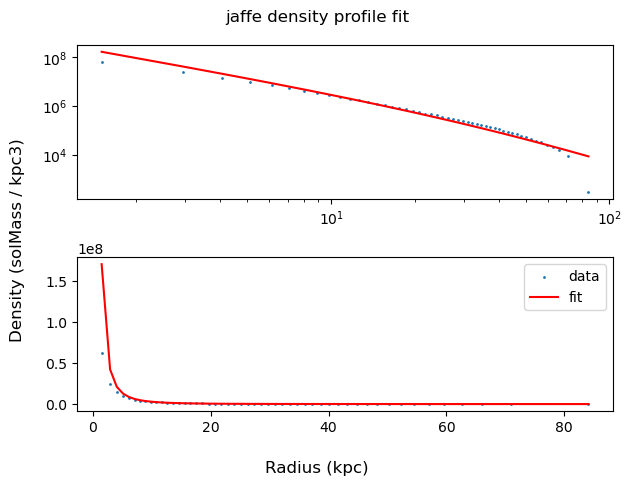

In [180]:
plotdensityfit(potential = "jaffe", nr_bins = 50, bin_distr = "adaptive")

STD of the parameters: [1.28726951e+10 1.48138375e+00]
optimal parameters for nfw: [<Quantity 9.09768238e+10 solMass>, <Quantity 6.13382579 kpc>]
RMSE of nfw fit: 0.23768363402018644
RSQUARED of nfw fit: 0.9387487085010376


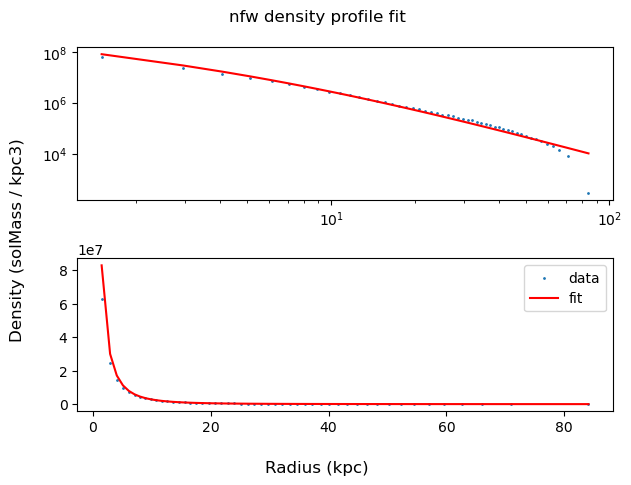

In [181]:
plotdensityfit(potential = "nfw", nr_bins = 50, bin_distr = "adaptive")

C:\Users\niels\AppData\Local\Temp\ipykernel_13884\1058241007.py:103: RuntimeWarning: invalid value encountered in power
  density = (ampl_solm / (a_kpc**3)) * (a_kpc / r_kpc)**alpha
C:\Users\niels\AppData\Local\Temp\ipykernel_13884\1058241007.py:104: RuntimeWarning: invalid value encountered in log10
  return np.log10(density)


STD of the parameters: [5.71574281e+15 1.01096934e+08 1.09256624e-01]
optimal parameters for powerspherical: [<Quantity 8.12813577e+09 solMass>, <Quantity 81.97158036 kpc>, np.float64(2.429826468536846)]
RMSE of powerspherical fit: 0.28291094797742783
RSQUARED of powerspherical fit: 0.9132206884501632


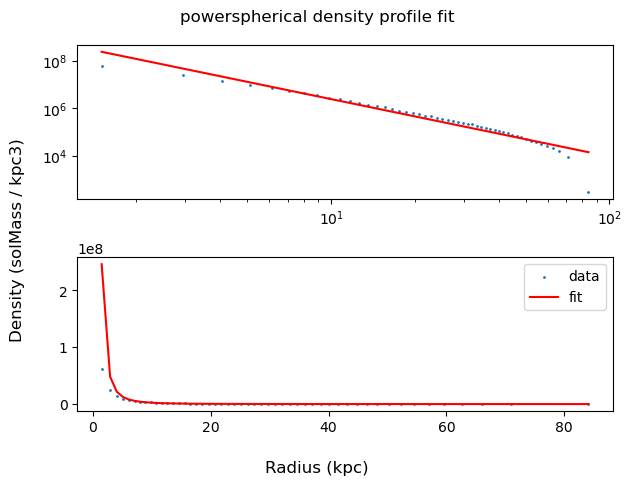

In [182]:
plotdensityfit(potential = "powerspherical", nr_bins = 50, bin_distr = "adaptive")

C:\Users\niels\AppData\Local\Temp\ipykernel_13884\1058241007.py:113: RuntimeWarning: invalid value encountered in log10
  return np.log10(density)
C:\Users\niels\AppData\Local\Temp\ipykernel_13884\1058241007.py:112: RuntimeWarning: invalid value encountered in power
  density = ampl_solm * ((a_kpc/r_kpc)**alpha) * np.exp(-(r_kpc/cutoff_kpc)**2)


STD of the parameters: [3.23992269e+14 6.40281290e+05 1.45828573e+00 6.99713789e-02]
optimal parameters for powersphericalwcutoff: [<Quantity 1.66620546e+08 solMass>, <Quantity 0.46372382 kpc>, <Quantity 47.25411148 kpc>, np.float64(1.4082983649329581)]
RMSE of powersphericalwcutoff fit: 0.3401695231239835
RSQUARED of powersphericalwcutoff fit: 0.9745618164369556


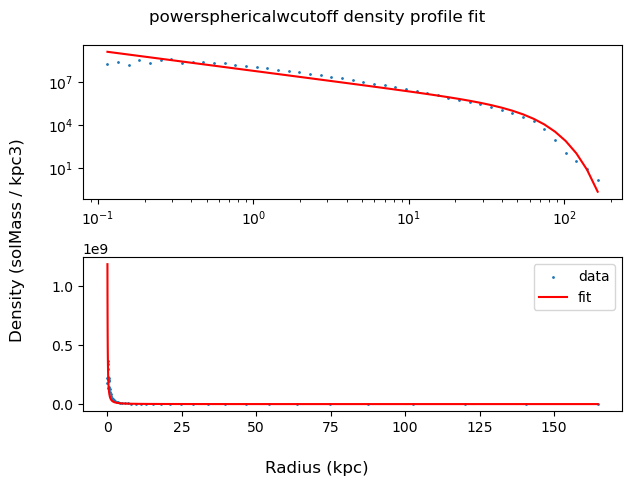

In [183]:
plotdensityfit(potential = "powersphericalwcutoff", nr_bins = 50, bin_distr = "logarithmic")

C:\Users\niels\AppData\Local\Temp\ipykernel_13884\1058241007.py:124: RuntimeWarning: invalid value encountered in log10
  return np.log10(density)


STD of the parameters: [3.36771969e+08 2.19397966e-01]
optimal parameters for pseudoisothermal: [<Quantity 4.79762489e+08 solMass>, <Quantity 0.4843511 kpc>]
RMSE of pseudoisothermal fit: 0.8351524214299524
RSQUARED of pseudoisothermal fit: 0.8466701242349417


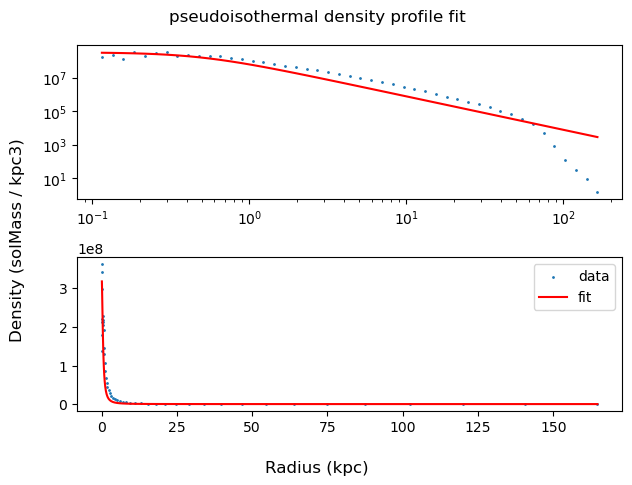

In [184]:
plotdensityfit(potential = "pseudoisothermal", nr_bins = 50, bin_distr = "logarithmic")